# Hand-Writing Recognition

In [2]:
#Installing necessary module
!pip install keras-tqdm

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Importing necessary Module
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
import tensorflow as tf

In [5]:
# Reading the txt file after downloading
with open('parser.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents] 
lines[0]

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [6]:
# Defining function to convert each word to encoded text, give an ID to each character
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [7]:
images = []
labels = []
# to take the first 10000 instances for training and testing of the model
RECORDS_COUNT = 10000

In [8]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [9]:
# Image reshaping and normalizing:

def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
# Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
# Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
# To Normalize the image:

    img = img / 255
    
    return img

# Generating train & validation set

In [10]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'D:/OneDrive - Adani/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        # processing the image:
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # processing the label:
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [11]:
# Padding all the words to have a similar length:

train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [37]:
print(train_padded_label.shape)
print(valid_padded_label.shape)

(7850, 16)
(876, 16)


In [13]:
# Converting image into numpy array

train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [14]:
print(train_images.shape)

(7850, 32, 128, 1)

# Building Model
Convolutional Recurrent Neural Network

In [15]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [16]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 32, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [17]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [18]:
batch_size = 8
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [19]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [20]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/30

Epoch 1: val_loss improved from inf to 14.44493, saving model to sgdo-10000r-30e-7850t-876v.hdf5


C:\Users\30006140\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


982/982 - 602s - loss: 15.5551 - accuracy: 0.0000e+00 - val_loss: 14.4449 - val_accuracy: 0.0000e+00 - 602s/epoch - 613ms/step
Epoch 2/30

Epoch 2: val_loss improved from 14.44493 to 13.97846, saving model to sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 589s - loss: 13.1054 - accuracy: 0.0118 - val_loss: 13.9785 - val_accuracy: 0.0502 - 589s/epoch - 600ms/step
Epoch 3/30

Epoch 3: val_loss improved from 13.97846 to 13.63787, saving model to sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 2289s - loss: 11.3743 - accuracy: 0.0531 - val_loss: 13.6379 - val_accuracy: 0.0080 - 2289s/epoch - 2s/step
Epoch 4/30

Epoch 4: val_loss improved from 13.63787 to 10.97360, saving model to sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 580s - loss: 9.6495 - accuracy: 0.0852 - val_loss: 10.9736 - val_accuracy: 0.0799 - 580s/epoch - 590ms/step
Epoch 5/30

Epoch 5: val_loss improved from 10.97360 to 10.08473, saving model to sgdo-10000r-30e-7850t-876v.hdf5
982/982 - 8976s - loss: 7.8058 - accuracy: 0.1332 - val_loss: 

# Test Accuracy

In [22]:
!pip install Levenshtein

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for Levenshtein from https://files.pythonhosted.org/packages/2f/04/a557197d0ba601f09fdd9ef9174b61d87706a291cd1e1578728eda3f44ab/Levenshtein-0.23.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for rapidfuzz<4.0.0,>=3.1.0 from https://files.pythonhosted.org/packages/89/49/e95e84ed1e5c3c69ea8849d06f8f475c41303533c86710b1c01a4f50d353/rapidfuzz-3.5.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/101.1 kB ? eta -:--:--
   ---------------------------- ----------- 71.7/101.1 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 101.1/101.1 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.7 MB 9.6 MB/s eta 0:00:01
   ------------------- -------------------- 0.8/1.7 MB 10.5 MB/s eta 0:00:01
   ------------------------


[notice] A new release of pip is available: 23.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# loading the saved best model weights
act_model.load_weights(filepath)

# predicting outputs on validation images
prediction = act_model.predict(valid_images)
 
# using CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

# To check Similarity between the original and predicted text (to measure of similarity between two strings)
import Levenshtein as lv

total_jaro = 0
total_rati = 0
# To see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

28/28 [==============================] - 9s 335ms/step
jaro : 0.9114669714270177
ratio: 0.8813694332704262


1/1 [==============================] - 0s 144ms/step
original_text =   week-end
predicted text = weeler-hnd

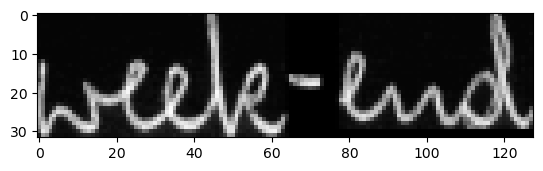

original_text =   "
predicted text = "

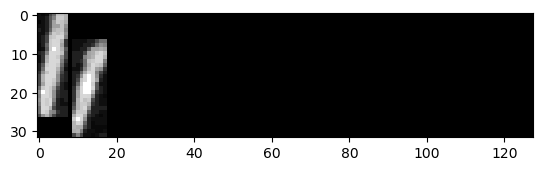

original_text =   Roy's
predicted text = hoys

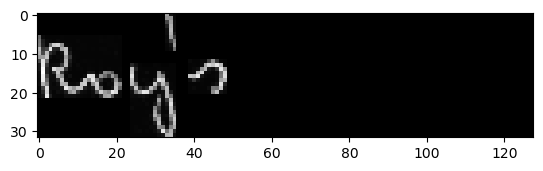

original_text =   the
predicted text = the

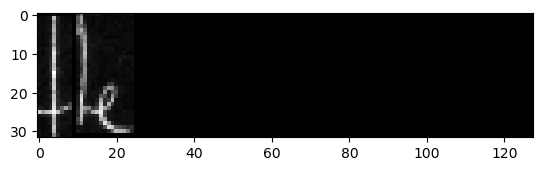

original_text =   because
predicted text = kecuse

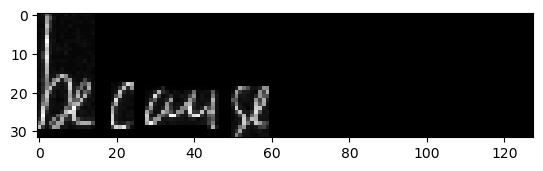

original_text =   were
predicted text = were

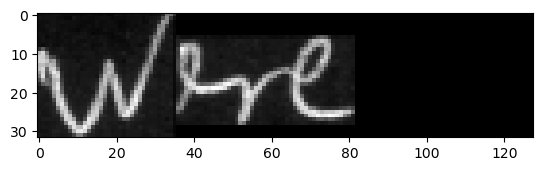

original_text =   by
predicted text = by

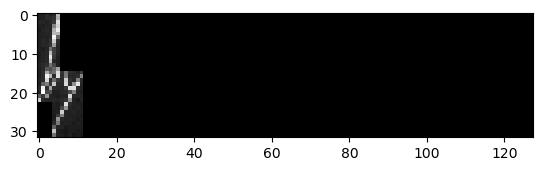

original_text =   talks
predicted text = salls

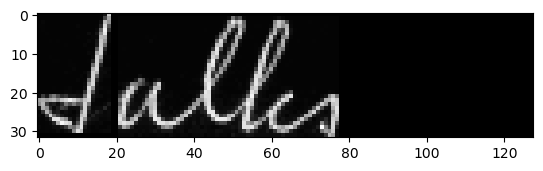

original_text =   today
predicted text = today

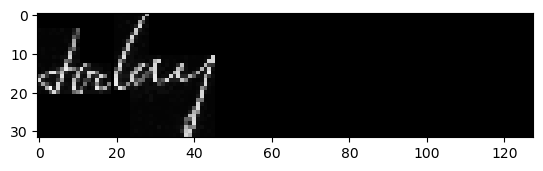

original_text =   Minister
predicted text = Muriniter

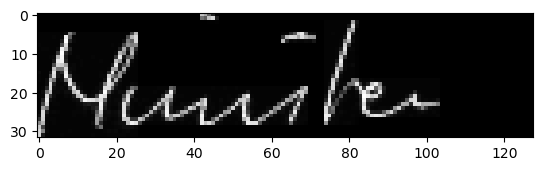

original_text =   will
predicted text = willth

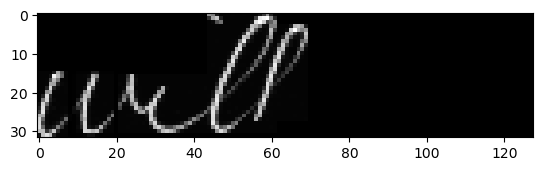

original_text =   Government
predicted text = Govervmt

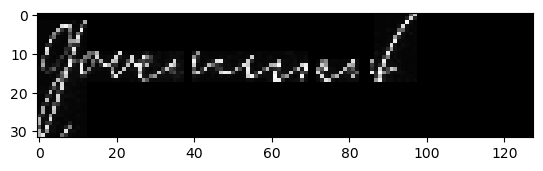

original_text =   Lancaster
predicted text = Lancaster

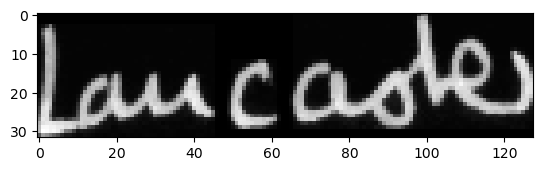

original_text =   the
predicted text = the

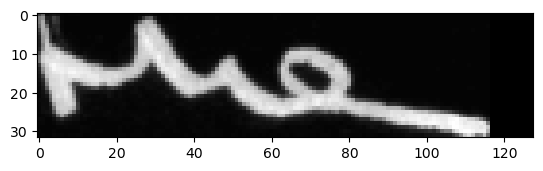

original_text =   It
predicted text = It

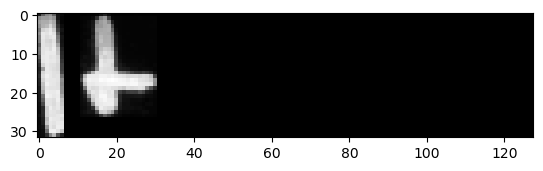

original_text =   the
predicted text = Hhe

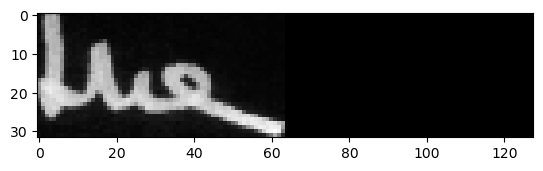

original_text =   Weaver
predicted text = Weover

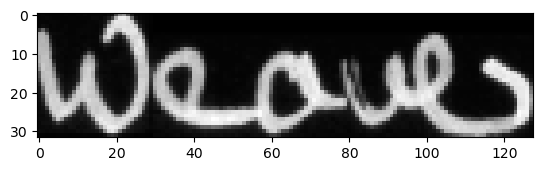

original_text =   be
predicted text = be

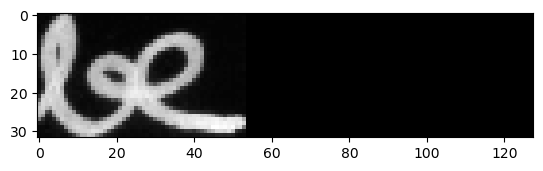

original_text =   and
predicted text = and

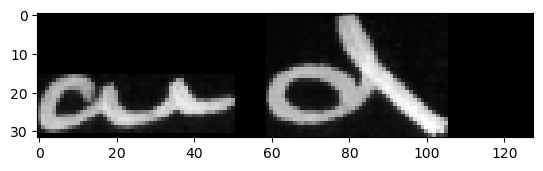

original_text =   will
predicted text = with

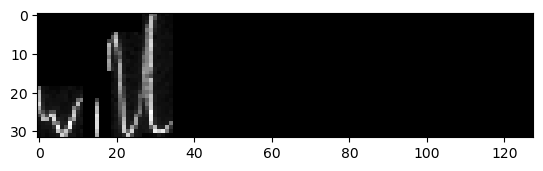

In [40]:
# predict outputs on validation images
prediction = act_model.predict(valid_images[150:170])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", valid_original_text[150+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(valid_images[150+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    #print('\n')

In [35]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

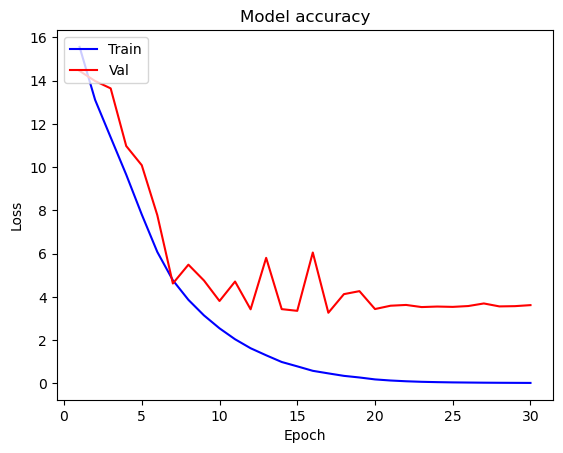

In [36]:
# Model Loss vs Epoch
plotgraph(epochs, loss, val_loss)

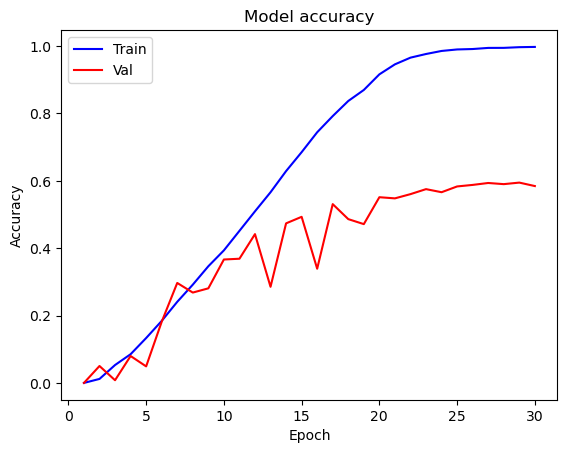

In [32]:
# Model Accuracy vs Epoch
plotgraph(epochs, acc, val_acc)

In [33]:
# get best model index
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [34]:
# Storing best model parameters:
with open('history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath, 
                                                      optimizer_name, 
                                                      str(RECORDS_COUNT), 
                                                      e, 
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]), 
                                                      best_loss, 
                                                      best_acc, 
                                                      best_val_loss, 
                                                      best_val_acc)
    f.write(new_data)